### **CARTPOLE DQN KERAS**

This is a naive version of the CARTPOLE DQN algorithm <br>
It converges in 87 episodes  <br>
 <br>
Try to make it faster by doing some hyperparameter optimization  <br>
Try to explore less. Does it accelerates convergence?  <br>
Increasing the ROLLING_WINDOW it will converge slower but the Agent behavior will be more consistent

In [15]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import random
import gymnasium as gym
import time
import numpy as np
from collections import deque
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

# Use mixed-precision training for faster computations on supported GPUs
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Enable XLA (Accelerated Linear Algebra) optimization
tf.config.optimizer.set_jit(True)
tf.config.optimizer.set_jit(True)

import sys
sys.stderr = open('err.txt', 'w')

Using device: 0, name: NVIDIA T600 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 7.5


#### **Hyperparameters**

In [2]:

MAX_EPISODES = 300
ROLLING_WINDOW = 20
MEMORY_SIZE = 2000
MAX_STEPS = 500

gamma = 0.95                         # discount rate
epsilon = 1.0                        # exploration rate
epsilon_min = 0.01
epsilon_decay = 0.98
learning_rate = 0.001
batch_size = 64
solved_threshold = 195

verb = 0                             # to see traces (verbosity)

In [3]:
# Environment setup
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

#### **Neural Network**

In [13]:
def build_model(state_size, action_size):
    inputs = Input(shape=(state_size,), name="state_input")
    x = Dense(24, activation='relu', name="dense_1")(inputs)
    x = Dense(24, activation='relu', name="dense_2")(x)
    outputs = Dense(action_size, activation='linear', name="output_layer")(x)
    
    model = Model(inputs=inputs, outputs=outputs, name="Q_Network")
#    model.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mse') # to improve train stability
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return model

#### **Support Functions**

In [14]:
replay_buffer = deque(maxlen=MEMORY_SIZE)

def store(state, action, reward, next_state, done):             # memorize
    replay_buffer.append((state, action, reward, next_state, done))

def select_action_greedy(state, DQN):                                      # act
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    act_values = DQN.predict(state, verbose=verb)
    return np.argmax(act_values[0])  # returns action selected with greedy strategy

# Sample experiences from the replay buffer
def sample_experiences(batch_size):
    indices = np.random.choice(len(replay_buffer), batch_size, replace=False)
    batch = [replay_buffer[i] for i in indices]
    states, actions, rewards, next_states, dones = zip(*batch)
    return (
        np.vstack(states),
        np.array(actions),
        np.array(rewards),
        np.vstack(next_states),
        np.array(dones, dtype=np.float32)
    )

    
def experience_replay(batch_size, model, epsilon):
    if len(replay_buffer) < batch_size:
        return
    minibatch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = sample_experiences(batch_size)

    # Predict Q-values for current and next states using vectorized operations
    target_qs = model.predict(states, verbose=verb)
    next_qs   = model.predict(next_states, verbose=verb)

    # Update target Q-values using standard DQN logic   
    target_qs[np.arange(batch_size), actions] = rewards + gamma * np.max(next_qs, axis=1) * (1 - dones)
    
#    for i in range(batch_size):
#        if dones[i]:
#            target_qs[i, actions[i]] = rewards[i]
#        else:
#            target_qs[i, actions[i]] = rewards[i] + gamma * np.max(next_qs[i])

    # Train the model on the Q-values
    model.fit(states, target_qs, epochs=1, verbose=0)

def load(name, DQN):
    DQN.load_weights(name)

def save(name, DQN):
    DQN.save_weights(name)

DQN = build_model(state_size, action_size)
DQN.summary()

Model: "Q_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ state_input (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_3 (Cast)                   │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770 (3.01 KB)

 Trainable params: 770 (3.01 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
rewards_per_episode= []

done = False
rolling_avg = 0
rolling_avg_rewards = []

for e in range(MAX_EPISODES):                           # Should be While True, however we limit number of eps
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    for step in range(MAX_STEPS):
            
        action = select_action_greedy(state, DQN)
        next_state, reward, done, truncated , _ = env.step(action)
                    
        next_state = np.reshape(next_state, [1, state_size])
        store(state, action, reward, next_state, done)
        state = next_state
        total_reward = total_reward + reward
        if done:
            break
            
        if len(replay_buffer) > batch_size:
            experience_replay(batch_size, DQN, epsilon)
            
    epsilon = max(epsilon_min, epsilon * epsilon_decay)            # decay epsilon
    
    rewards_per_episode.append(total_reward)
    rolling_avg = np.mean(rewards_per_episode[-ROLLING_WINDOW:])   # append rewards
    rolling_avg_rewards.append(rolling_avg)
    print(f"Episode: {e+1:3}/{MAX_EPISODES}, Reward: {total_reward:+7.2f}, "
          f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:6.2f}, Steps: {step:3} Terminated: {done} ")

            
    # Check if environment is solved
    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {e+1} episodes!")
#            model.save("lunarlander_ddqn_model1.keras")
        break

Model: "Q_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ state_input (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770 (3.01 KB)

 Trainable params: 770 (3.01 KB)

 Non-trainable params: 0 (0.00 B)

Episode:   1/300, Reward:  +33.00, Epsilon: 0.98, Rolling Avg:  33.00, Steps:  32 Terminated: True 
Episode:   2/300, Reward:  +10.00, Epsilon: 0.96, Rolling Avg:  21.50, Steps:   9 Terminated: True 
Episode:   3/300, Reward:  +16.00, Epsilon: 0.94, Rolling Avg:  19.67, Steps:  15 Terminated: True 
Episode:   4/300, Reward:  +17.00, Epsilon: 0.92, Rolling Avg:  19.00, Steps:  16 Terminated: True 
Episode:   5/300, Reward:  +42.00, Epsilon: 0.90, Rolling Avg:  23.60, Steps:  41 Terminated: True 
Episode:   6/300, Reward:  +16.00, Epsilon: 0.89, Rolling Avg:  22.33, Steps:  15 Terminated: True 
Episode:   7/300, Reward:  +26.00, Epsilon: 0.87, Rolling Avg:  22.86, Steps:  25 Terminated: True 
Episode:   8/300, Reward:  +20.00, Epsilon: 0.85, Rolling Avg:  22.50, Steps:  19 Terminated: True 
Episode:   9/300, Reward:  +12.00, Epsilon: 0.83, Rolling Avg:  21.33, Steps:  11 Terminated: True 
Episode:  10/300, Reward:  +22.00, Epsilon: 0.82, Rolling Avg:  21.40, Steps:  21 Terminated: True 


Episode:  83/300, Reward:  +73.00, Epsilon: 0.19, Rolling Avg: 170.15, Steps:  72 Terminated: True 
Episode:  84/300, Reward: +169.00, Epsilon: 0.18, Rolling Avg: 176.75, Steps: 168 Terminated: True 
Episode:  85/300, Reward: +318.00, Epsilon: 0.18, Rolling Avg: 187.85, Steps: 317 Terminated: True 
Episode:  86/300, Reward: +370.00, Epsilon: 0.18, Rolling Avg: 194.85, Steps: 369 Terminated: True 
Episode:  87/300, Reward: +279.00, Epsilon: 0.17, Rolling Avg: 199.40, Steps: 278 Terminated: True 
Environment solved in 87 episodes!


#### **Learning Plot and Episode Rewards**

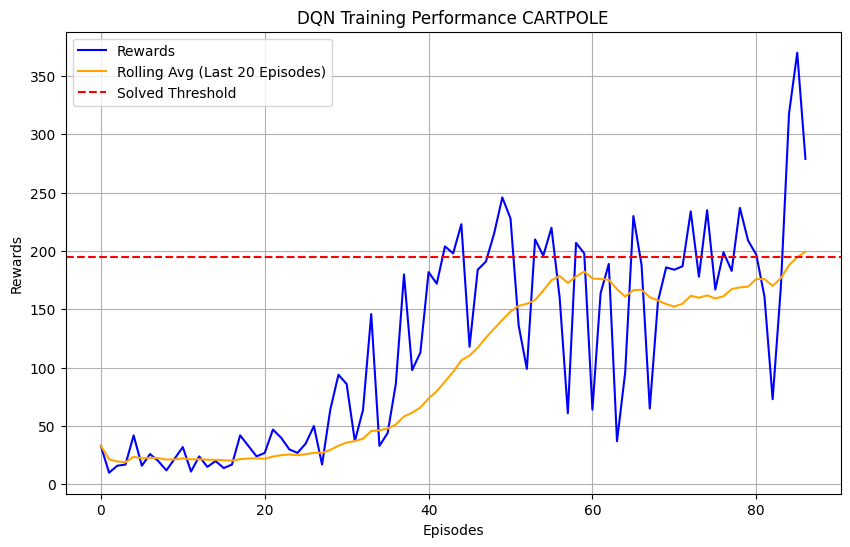

In [7]:
# Plot rewards with rolling average

plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last 20 Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('DQN Training Performance CARTPOLE')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

#### **Simulation - Testing 10 episodes with the DQN Network**

In [8]:
# Testing for 10 episodes
start_time = time.time()

for e_test in range(10):  # Run 10 test episodes
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    steps = 0
    while True:
        # Use the trained model for testing
        action_vals = DQN.predict(state, verbose=0)  # Predict action values
        action = np.argmax(action_vals[0])  # Choose the action with the highest Q-value

        next_state, reward, done, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        steps = steps + 1
        if done or truncated:
            print(f"Test Episode: {e_test + 1:2}/10, Reward: {total_reward:.2f}, Steps: {steps:3}")
            break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Testing completed in {testing_duration:.2f} minutes")

Test Episode:  1/10, Reward: 190.00, Steps: 190
Test Episode:  2/10, Reward: 219.00, Steps: 219
Test Episode:  3/10, Reward: 206.00, Steps: 206
Test Episode:  4/10, Reward: 184.00, Steps: 184
Test Episode:  5/10, Reward: 185.00, Steps: 185
Test Episode:  6/10, Reward: 199.00, Steps: 199
Test Episode:  7/10, Reward: 222.00, Steps: 222
Test Episode:  8/10, Reward: 182.00, Steps: 182
Test Episode:  9/10, Reward: 198.00, Steps: 198
Test Episode: 10/10, Reward: 300.00, Steps: 300
Testing completed in 3.54 minutes


#### **Rendering 1 episode**

In [9]:
# Test the trained agent with video rendering
# This code is useful if you are using colab otherwise use render_mode='human'
env = gym.make(("CartPole-v1"), render_mode='rgb_array')  # Enable RGB rendering
frames = []  # Store frames for visualization

# Render a single test episode
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
tot_rewards = 0

while True:
    # Use the trained model for action
    action_vals = DQN.predict(state, verbose=0)  # Predict action values
    action = np.argmax(action_vals[0])           # Choose the action with the highest Q-value

    next_state, reward, done, truncated, _ = env.step(action)
    frames.append(env.render())                  # Save frame for rendering later
    next_state = np.reshape(next_state, [1, state_size])
    tot_rewards += reward
    state = next_state

    if done or truncated:
        print(f"Rendered Test Episode Reward: {tot_rewards:.2f}")
        break

env.close()

# Save the rendered episode as a GIF
def save_frames_as_gif(frames, path='./', filename='CARTPOLE_DQN.gif'):
    images = [Image.fromarray(frame) for frame in frames]
    gif_path = os.path.join(path, filename)
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=50, loop=0)
    print(f"Saved GIF to: {gif_path}")

save_frames_as_gif(frames, filename='CARTPOLE_DQN.gif')


Rendered Test Episode Reward: 197.00
Saved GIF to: ./CARTPOLE_DQN.gif


In [10]:
import session_info
session_info.show(html=False)

-----
PIL                 11.0.0
gymnasium           1.0.0
keras               3.6.0
matplotlib          3.9.2
numpy               1.26.4
session_info        1.0.0
tensorflow          2.17.1
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Jan 17 2025, 18:03:48) [GCC 13.3.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-02-01 22:14
